In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load the data
data_path = 'stage3_data_cleaning/v2/type1_label_merged_final_decoded_clean3.xlsx'
df = pd.read_excel(data_path)

In [2]:
df.head()

,label,timestamp,can_id,data_length,source_node_id_decimal,service_flag,priority,message_type_decimal,destination_node_id_decimal,request_or_response,...,end_of_message,single_message_frame,transfer_ID,effective_data_0,effective_data_1,effective_data_2,effective_data_3,effective_data_4,effective_data_5,effective_data_6
0,0,0.000000,10015501,8,1,0,16,341,-99,-99,...,1,1,0,0,0,0,0,8,0,0
1,0,0.192053,104E2001,2,1,0,16,20000,-99,-99,...,1,1,0,0,-199,-199,-199,-199,-199,-199
2,0,0.192335,1F043901,8,1,0,31,1081,-99,-99,...,0,0,0,0,0,0,246,0,-199,-199
3,0,0.192504,1F043901,8,1,0,31,1081,-99,-99,...,0,0,0,0,248,0,0,247,255,223
4,0,0.192637,1F043901,4,1,0,31,1081,-99,-99,...,1,0,0,254,0,0,-199,-199,-199,-199


In [3]:
def create_graph(df, start, window_size=200):
    G = nx.DiGraph()
    window_df = df.iloc[start:start+window_size]
    for i in range(len(window_df) - 1):
        node1 = window_df.iloc[i]['can_id']
        node2 = window_df.iloc[i+1]['can_id']
        timestamp_diff = window_df.iloc[i+1]['timestamp'] - window_df.iloc[i]['timestamp']
        
        if node1 != node2:  # Avoid self-loops
            if G.has_edge(node1, node2):
                G[node1][node2]['weight'] += timestamp_diff
            else:
                G.add_edge(node1, node2, weight=timestamp_diff)
    
    return G

In [4]:
def calculate_pagerank(G):
    pagerank = nx.pagerank(G, weight='weight')
    nx.set_node_attributes(G, pagerank, 'pagerank')
    return G

In [5]:
def visualize_graph(G):
    pos = nx.spring_layout(G)
    pagerank = nx.get_node_attributes(G, 'pagerank')
    labels = {node: f'{node}\nPR: {pagerank[node]:.2f}' for node in G.nodes()}
    
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, labels=labels, node_size=7000, node_color='skyblue', font_size=10)
    plt.show()

In [6]:
def generate_all_graphs(df, window_size=200):
    graphs = []
    step_size = int(window_size * 0.75)
    max_timestamp = df['timestamp'].max()
    end_time = 0.75 * max_timestamp
    
    for start in tqdm(range(0, len(df) - window_size, step_size)):
        window_df = df.iloc[start:start+window_size]
        if window_df['timestamp'].iloc[-1] > end_time:
            break
        
        G = create_graph(df, start, window_size)
        G = calculate_pagerank(G)
        graphs.append(G)
    
    return graphs

# Generate and store all graphs
all_graphs = generate_all_graphs(df)

 73%|███████▎  | 1014/1385 [00:53<00:19, 18.96it/s]


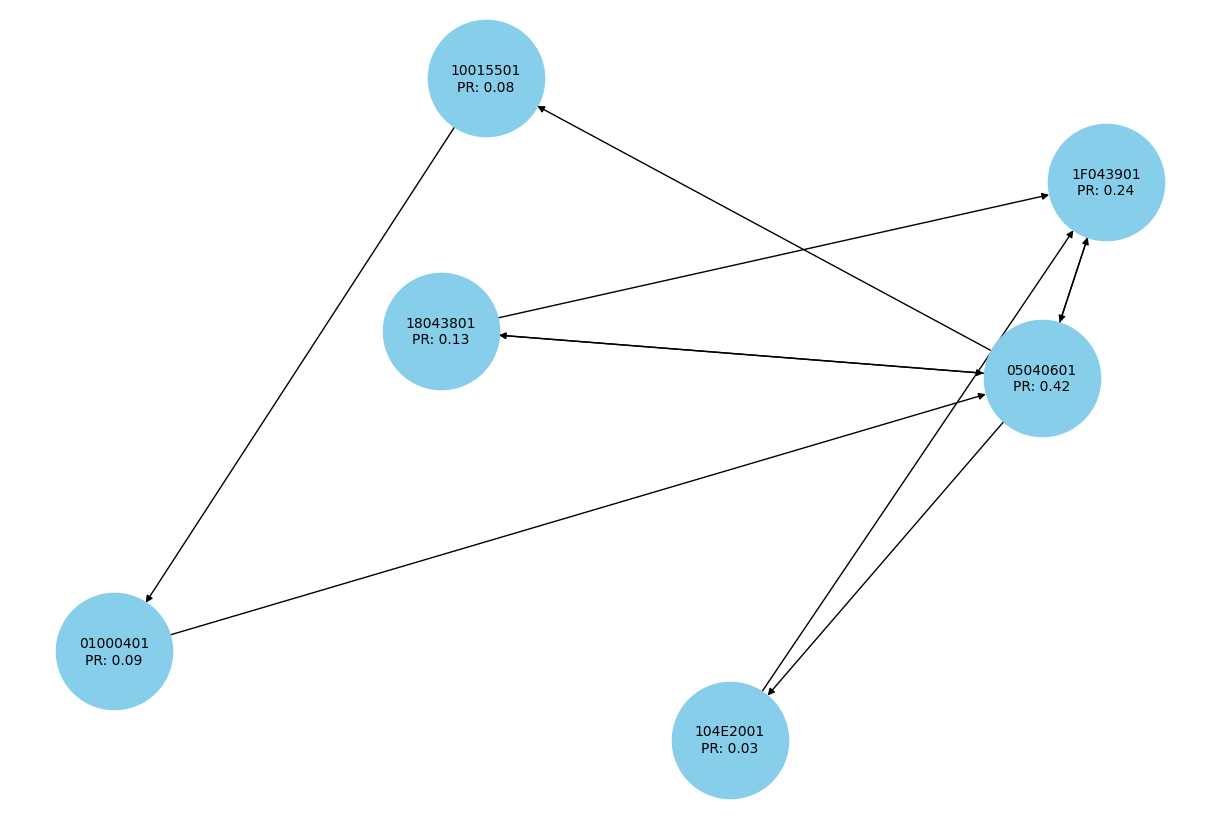

In [8]:
# Visualize the first graph as an example
visualize_graph(all_graphs[1])

In [14]:
def calculate_optimized_pagerank(G, damping_factor=0.7):
    N = len(G)
    pagerank = {node: 1 / N for node in G}
    for _ in range(100):  # Iterate 100 times for convergence
        new_pagerank = {}
        for node in G:
            rank_sum = 0
            for neighbor in G.predecessors(node):
                weight_sum = sum([G[neighbor][succ]['weight'] for succ in G.successors(neighbor)])
                rank_sum += pagerank[neighbor] * (G[neighbor][node]['weight'] / weight_sum)
            new_pagerank[node] = (1 - damping_factor) / N + damping_factor * rank_sum
        pagerank = new_pagerank
    nx.set_node_attributes(G, pagerank, 'pagerank')
    return G

In [20]:
def generate_all_graphs_optimized_page_rank(df, window_size=200):
    graphs = []
    step_size = 25
    max_timestamp = df['timestamp'].max()
    end_time = 0.75 * max_timestamp
    
    for start in tqdm(range(0, len(df) - window_size, step_size)):
        window_df = df.iloc[start:start+window_size]
        if window_df['timestamp'].iloc[-1] > end_time:
            break
        
        G = create_graph(df, start, window_size)
        G = calculate_optimized_pagerank(G)
        graphs.append(G)
    
    return graphs

# Generate and store all graphs
all_graphs2 = generate_all_graphs_optimized_page_rank(df)

 73%|███████▎  | 6082/8307 [05:15<01:55, 19.27it/s]


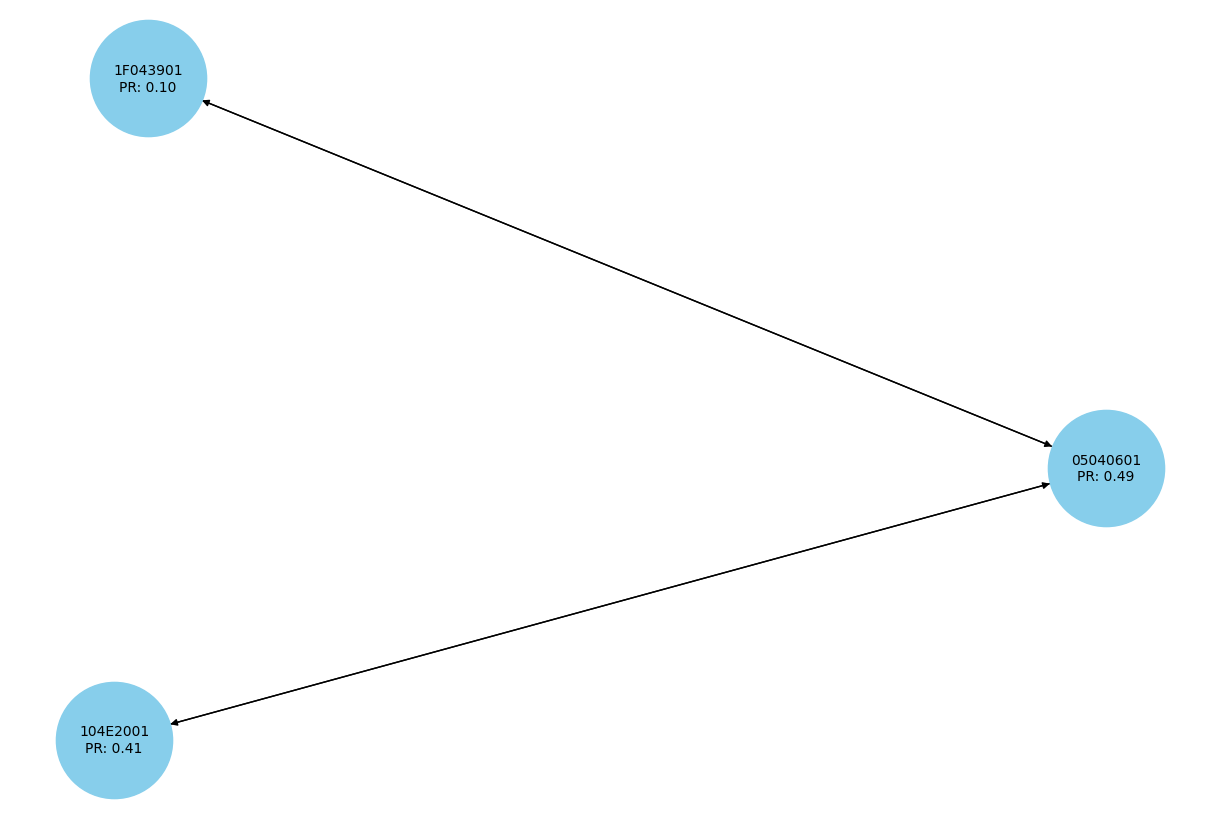

In [21]:
visualize_graph(all_graphs[1013])

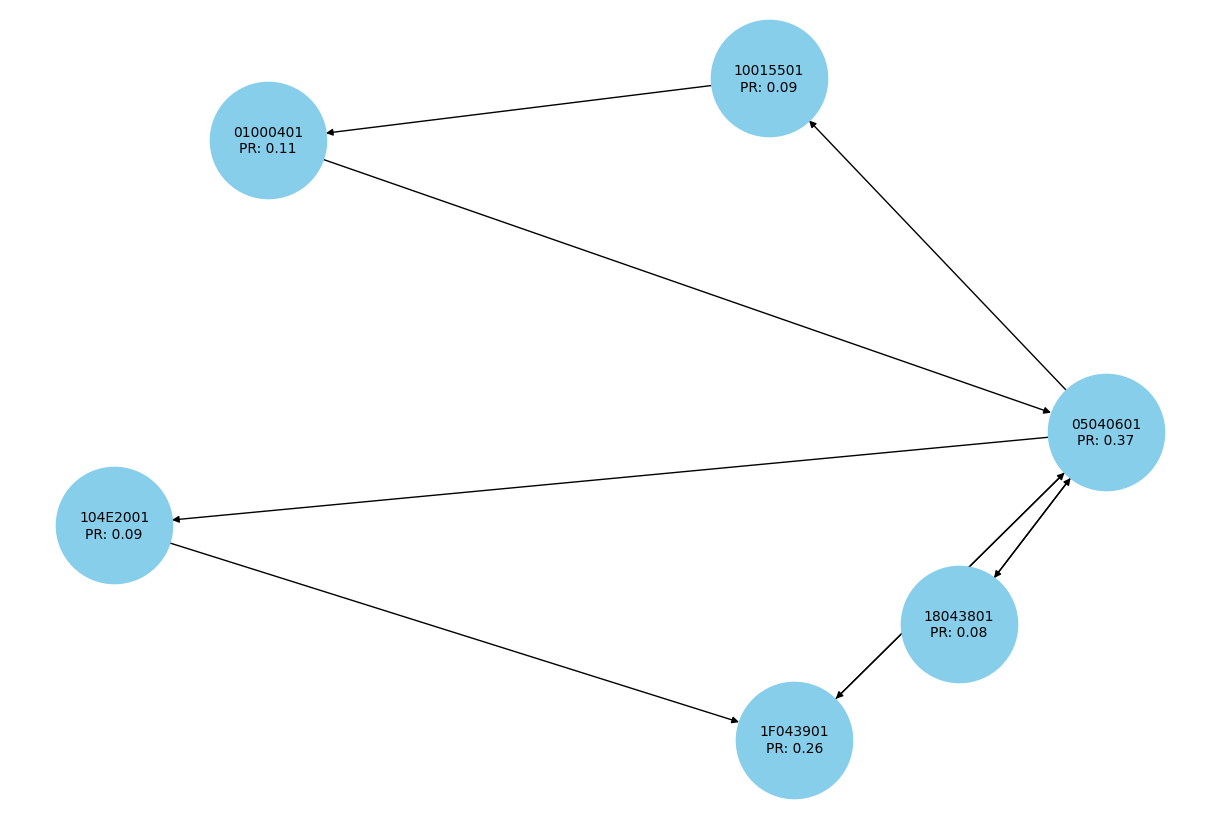

In [22]:
visualize_graph(all_graphs2[1])

# Time2Graph

In [24]:
df.columns

Index(['label', 'timestamp', 'can_id', 'data_length', 'source_node_id_decimal',
       'service_flag', 'priority', 'message_type_decimal',
       'destination_node_id_decimal', 'request_or_response',
       'service_type_id_decimal', 'start_of_message', 'end_of_message',
       'single_message_frame', 'transfer_ID', 'effective_data_0',
       'effective_data_1', 'effective_data_2', 'effective_data_3',
       'effective_data_4', 'effective_data_5', 'effective_data_6'],
      dtype='object')

In [29]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def extract_time_aware_shapelets(df, segment_length=200):
    shapelets = []
    labels = df['label'].unique()
    scaler = MinMaxScaler()
    
    for label in labels:
        class_data = df[df['label'] == label]
        for i in range(0, len(class_data) - segment_length + 1):
            segment = class_data.iloc[i:i+segment_length]
            scaled_segment = scaler.fit_transform(segment[['timestamp']])
            shapelets.append((scaled_segment.flatten(), label))
    
    return shapelets

shapelets = extract_time_aware_shapelets(df)


In [30]:
len(shapelets),df.shape

(207460, (207858, 22))

In [26]:
import networkx as nx

def construct_shapelet_evolution_graph(shapelets, distance_threshold=0.1):
    G = nx.DiGraph()
    
    for i in range(len(shapelets) - 1):
        for j in range(i + 1, len(shapelets)):
            shapelet_i, label_i = shapelets[i]
            shapelet_j, label_j = shapelets[j]
            
            distance = np.linalg.norm(shapelet_i - shapelet_j)
            if distance < distance_threshold:
                G.add_edge(i, j, weight=distance)

    # Calculate PageRank
    pagerank = nx.pagerank(G, weight='weight')
    nx.set_node_attributes(G, pagerank, 'pagerank')
    
    
    return G

G = construct_shapelet_evolution_graph(shapelets)


KeyboardInterrupt: 

In [ ]:
from karateclub import DeepWalk

def learn_representations(G, embedding_size=128):
    model = DeepWalk(dimensions=embedding_size)
    model.fit(G)
    embeddings = model.get_embedding()
    return embeddings

embeddings = learn_representations(G)


In [ ]:
# Visualize embeddings using PCA
def visualize_embeddings(embeddings):
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)
    
    plt.figure(figsize=(10, 10))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c='blue', marker='o')
    plt.title('Shapelet Embeddings')
    plt.show()

# Example usage
visualize_embeddings(embeddings)

In [ ]:
import torch
from torch_geometric.data import Data, DataLoader

def create_pyg_dataset(embeddings, shapelets):
    edge_index = torch.tensor([list(e) for e in G.edges()], dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor([G[u][v]['weight'] for u, v in G.edges()], dtype=torch.float)

    data_list = []
    for i, (embedding, (shapelet, label)) in enumerate(zip(embeddings, shapelets)):
        x = torch.tensor(embedding, dtype=torch.float).unsqueeze(0)
        y = torch.tensor([label], dtype=torch.long)
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
        data_list.append(data)
    
    return data_list

dataset = create_pyg_dataset(embeddings, shapelets)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [ ]:
import joblib
import os

# Create a directory for saving models
os.makedirs('models', exist_ok=True)

# Save function
def save_model(model, model_name):
    joblib.dump(model, f'models/{model_name}.joblib')

# Load function
def load_model(model_name):
    return joblib.load(f'models/{model_name}.joblib')


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def apply_nn_ed(dataset):
    X = [data.x.numpy().flatten() for data in dataset]
    y = [data.y.item() for data in dataset]
    
    knn = KNeighborsClassifier(metric='euclidean')
    knn.fit(X, y)
    y_pred = knn.predict(X)
    
    return accuracy_score(y, y_pred), y_pred

# Apply NN-ED
accuracy, y_pred = apply_nn_ed(dataset)
print(f'NN-ED Accuracy: {accuracy}')


In [ ]:

def visualize_graph(G, y_pred, anomaly_indices):
    pos = nx.spring_layout(G)
    labels = nx.get_node_attributes(G, 'pagerank')
    
    plt.figure(figsize=(12, 8))
    
    node_colors = ['red' if i in anomaly_indices else 'black' for i in range(len(y_pred))]
    nx.draw(G, pos, with_labels=True, node_color=node_colors, labels=labels, node_size=700, font_size=10, font_color='white')
    plt.show()

# Example visualization
anomaly_indices = [i for i, label in enumerate(y_pred) if label == 1]  # Assuming 1 indicates an anomaly
visualize_graph(G, y_pred, anomaly_indices)